In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import math
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score
from matplotlib import pyplot as plt
from sklearn import tree

In [75]:
df=pd.read_csv("diamonds.csv")

In [3]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


## Feature Engineering 

In [6]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [76]:
df_copy=df.copy()

In [77]:
df["price"] = np.log(df.price)
y_price=df["price"].copy()

In [78]:
def train_cats(df):
    for n,c in df.items():
         if is_string_dtype(c):
                df[n]=c.astype("category").cat.as_ordered()

In [79]:
def apply_cats(df,train):
    for n,c in df.items():
        if train[n].dtype== "category":
            df[n]=pd.Categorical(c,categories=train[n].cat.categories,ordered=True)

In [80]:
train_cats(df)

In [12]:
df["cut"]

0            Ideal
1          Premium
2             Good
3          Premium
4             Good
           ...    
53935        Ideal
53936         Good
53937    Very Good
53938      Premium
53939        Ideal
Name: cut, Length: 53940, dtype: category
Categories (5, object): ['Fair' < 'Good' < 'Ideal' < 'Premium' < 'Very Good']

In [13]:
df["cut"].cat.categories

Index(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype='object')

In [14]:
df["cut"].cat.codes

0        2
1        3
2        1
3        3
4        1
        ..
53935    2
53936    1
53937    4
53938    3
53939    2
Length: 53940, dtype: int8

In [15]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,5.786897,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,5.786897,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,5.789960,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,5.811141,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,5.814131,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,7.921898,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,7.921898,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,7.921898,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,7.921898,6.15,6.12,3.74


In [81]:
y=df["price"]
df=df.drop(["price"],axis=1)

In [17]:
df

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74


In [82]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1
        
for n, c in df.items():
    numericalize(df, c, n)

In [83]:
df

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,3,2,4,61.5,55.0,3.95,3.98,2.43
1,0.21,4,2,3,59.8,61.0,3.89,3.84,2.31
2,0.23,2,2,5,56.9,65.0,4.05,4.07,2.31
3,0.29,4,6,6,62.4,58.0,4.20,4.23,2.63
4,0.31,2,7,4,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,3,1,3,60.8,57.0,5.75,5.76,3.50
53936,0.72,2,1,3,63.1,55.0,5.69,5.75,3.61
53937,0.70,5,1,3,62.8,60.0,5.66,5.68,3.56
53938,0.86,4,5,4,61.0,58.0,6.15,6.12,3.74


In [20]:
rf=RandomForestRegressor(n_jobs=-1)
rf.fit(df,y)
rf.score(df,y)

0.9988914479301154

In [21]:
def split_train_validation(df,n):
    return df[:n].copy(),df[n:]

n_validation=3000
n_train=len(df)-n_validation
X_train,X_validation=split_train_validation(df,n_train)
y_train,y_validation=split_train_validation(y,n_train)

In [22]:
def get_sample(df,n):
    idxs=np.random.permutation(len(df))[:n]
    return idxs,df.iloc[idxs].copy()

In [23]:
idxs,X_train=get_sample(X_train,6000)
y_train = y_train[idxs]

In [24]:
X_train.shape,y_train.shape,X_validation.shape,y_validation.shape

((6000, 9), (6000,), (3000, 9), (3000,))

In [25]:
def rmsle(x,y):
     return math.sqrt(((x-y)**2).mean())

In [26]:
def print_(rf_m):
    print(f"accuracy train set {rmsle(rf_m.predict(X_train),y_train)}")
    print(f"accuracy valid set {rmsle(rf_m.predict(X_validation),y_validation)}")
    print(f"r^2 train set {rf_m.score(X_train,y_train)}")
    print(f"r^2 validation set{rf_m.score(X_validation,y_validation)}")

In [27]:
rf_m=RandomForestRegressor(n_jobs=-1)
%time rf_m.fit(X_train,y_train)
print_(rf_m)

Wall time: 1.14 s
accuracy train set 0.040995222821444674
accuracy valid set 0.13242808797433347
r^2 train set 0.9984445113155314
r^2 validation set0.9090544500526992


In [28]:
m_model= RandomForestRegressor(n_estimators=1, max_depth=2, n_jobs=-1)
print_(m_model.fit(X_train, y_train))

accuracy train set 0.339923692914194
accuracy valid set 0.563969488069841
r^2 train set 0.8930543249521856
r^2 validation set-0.6494245447261231


In [29]:
m_estimator=m_model.estimators_[0]

[Text(167.4, 181.2, 'y <= 5.655\nmse = 1.099\nsamples = 3782\nvalue = 7.787'),
 Text(83.7, 108.72, 'x <= 4.855\nmse = 0.208\nsamples = 1858\nvalue = 6.864'),
 Text(41.85, 36.23999999999998, 'mse = 0.08\nsamples = 1211\nvalue = 6.602'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 0.074\nsamples = 647\nvalue = 7.36'),
 Text(251.10000000000002, 108.72, 'y <= 7.075\nmse = 0.312\nsamples = 1924\nvalue = 8.696'),
 Text(209.25, 36.23999999999998, 'mse = 0.167\nsamples = 1414\nvalue = 8.452'),
 Text(292.95, 36.23999999999998, 'mse = 0.092\nsamples = 510\nvalue = 9.372')]

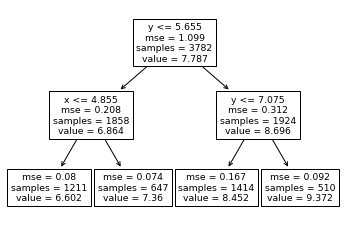

In [30]:
tree.plot_tree(m_estimator,feature_names=df.columns)

In [31]:
rf_model=RandomForestRegressor(n_estimators=1,bootstrap=False,n_jobs=-1).fit(X_train,y_train)

In [32]:
print_(rf_model)

accuracy train set 0.00025395742546769235
accuracy valid set 0.18346155302958606
r^2 train set 0.9999999403071678
r^2 validation set0.8254534105794481


In [33]:
#Overfitting

In [34]:
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, y_train)
print_(rf_model)

accuracy train set 0.041226259020330766
accuracy valid set 0.1334740330824878
r^2 train set 0.9984269294204567
r^2 validation set0.9076121622495092


In [35]:
preds=np.array([rf_model.predict(X_validation) for rf_model in rf_model.estimators_])

In [36]:
preds

array([[7.61233684, 7.675546  , 7.73979446, ..., 8.03106018, 8.25009775,
        7.73105314],
       [7.71690614, 7.70930833, 7.60589   , ..., 7.70074779, 7.93808873,
        7.95191138],
       [7.73061407, 7.70930833, 8.03818918, ..., 8.03106018, 8.05832731,
        7.73105314],
       ...,
       [8.02224092, 7.72665366, 7.71912984, ..., 7.94520113, 7.94378269,
        7.73105314],
       [7.72001794, 7.74586823, 7.73979446, ..., 7.92588032, 8.06557943,
        8.21932609],
       [7.74630066, 7.94732503, 7.74932246, ..., 7.97693876, 8.22201644,
        8.02387999]])

In [37]:
preds[:,0],np.mean(preds[:,0]),y_validation

(array([7.61233684, 7.71690614, 7.73061407, 7.66949525, 7.72709448,
        7.74630066, 7.64778605, 8.00536707, 7.64778605, 7.64778605,
        7.74630066, 7.72709448, 7.73105314, 7.69028602, 7.73072384,
        7.94271754, 7.64444076, 7.64778605, 7.64778605, 7.72709448,
        8.16451027, 7.74630066, 8.23880117, 7.70300768, 7.72709448,
        7.62461899, 7.73105314, 7.72929567, 7.72709448, 7.64778605,
        7.73032122, 7.73061407, 7.64778605, 7.73061407, 7.73105314,
        7.64778605, 7.96067261, 7.61233684, 7.63964229, 7.73061407,
        7.73039443, 7.73105314, 7.66949525, 7.73061407, 7.73083361,
        8.00369734, 7.62461899, 7.74630066, 7.73061407, 7.65302041,
        7.7393592 , 7.64635372, 7.72929567, 7.73105314, 7.64444076,
        7.7301748 , 7.64778605, 7.66949525, 7.63964229, 7.64754744,
        7.73061407, 7.73090678, 7.73083361, 7.70300768, 7.73083361,
        7.7301748 , 7.72709448, 7.63964229, 7.72709448, 8.01895468,
        7.74630066, 7.73071164, 7.73061404, 8.04

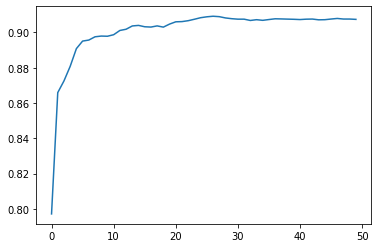

In [38]:
plt.plot([metrics.r2_score(y_validation,np.mean(preds[:i+1],axis=0)) for i in range(50)]);

In [39]:
rf_model=RandomForestRegressor(n_estimators=50,n_jobs=-1)
%time rf_model.fit(X_train,y_train)
print_(rf_model)

Wall time: 590 ms
accuracy train set 0.042363463257187206
accuracy valid set 0.13451973054088237
r^2 train set 0.9983389478509783
r^2 validation set0.9061588732826691


In [40]:
rf_model=RandomForestRegressor(n_estimators=60,n_jobs=-1)
%time rf_model.fit(X_train,y_train)
print_(rf_model)

Wall time: 690 ms
accuracy train set 0.04252726883558442
accuracy valid set 0.1325275303994784
r^2 train set 0.9983260775317189
r^2 validation set0.9089178137579752


In [41]:
rf_model=RandomForestRegressor(n_estimators=90,n_jobs=-1)
%time rf_model.fit(X_train,y_train)
print_(rf_model)

Wall time: 1.01 s
accuracy train set 0.041949893305665474
accuracy valid set 0.13031811423185527
r^2 train set 0.9983712213244756
r^2 validation set0.9119294294333494


In [42]:
rf_model=RandomForestRegressor(n_estimators=100,n_jobs=-1)
%time rf_model.fit(X_train,y_train)
print_(rf_model)

Wall time: 1.02 s
accuracy train set 0.04140234275019466
accuracy valid set 0.13237167420149257
r^2 train set 0.9984134630677142
r^2 validation set0.9091319183431756


Confidence based on tree variance

In [43]:
preds=np.array([rf_model.predict(X_validation) for rf_model in rf_model.estimators_])

In [44]:
preds

array([[7.64778605, 7.675546  , 7.69074316, ..., 7.97693876, 7.96206731,
        8.07402622],
       [7.72709448, 7.48605262, 7.73979446, ..., 7.97349996, 7.74370326,
        8.0330095 ],
       [7.55695057, 7.94732503, 7.71912984, ..., 8.28172399, 7.63723439,
        8.0839457 ],
       ...,
       [7.73105314, 7.675546  , 7.73979446, ..., 7.70074779, 8.05832731,
        7.97177612],
       [7.73105314, 7.70751219, 7.60589   , ..., 8.28172399, 7.95542509,
        7.94732503],
       [7.72709448, 7.70930833, 7.96067261, ..., 7.92984643, 7.93808873,
        8.02584334]])

In [45]:
np.mean(preds[:,0]),np.std(preds[:,0])

(7.754434959073463, 0.12434409364224247)

In [46]:
# standart sapma düşük, değişken confidence düşük 

In [47]:
np.mean(preds[:,0]),np.std(preds[:,0])

(7.754434959073463, 0.12434409364224247)

In [48]:
x=X_validation.copy()
y=y_validation.copy()

In [49]:
x=pd.concat([x, y_validation], axis=1)

In [50]:
x["pred_std"]=np.std(preds,axis=0)
x["pred"]=np.mean(preds,axis=0)

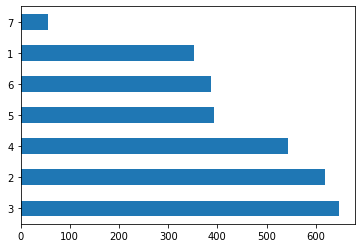

In [51]:
x["color"].value_counts().plot.barh();

In [52]:
x["color"].value_counts()

3    648
2    618
4    544
5    393
6    388
1    353
7     56
Name: color, dtype: int64

In [53]:
x["color"].sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of 50940    5
50941    2
50942    3
50943    4
50944    7
        ..
53935    1
53936    1
53937    1
53938    5
53939    1
Name: color, Length: 3000, dtype: int8>

In [54]:
fields=["color","pred","pred_std","price"]
x[fields].groupby("color",as_index=False).mean()

,color,pred,pred_std,price
0,1,7.597366,0.151267,7.587556
1,2,7.733272,0.149237,7.711143
2,3,7.723881,0.125481,7.741544
3,4,7.721060,0.130364,7.684189
4,5,7.729464,0.150393,7.667012
5,6,7.675868,0.153357,7.712573
6,7,7.847129,0.173838,7.811531


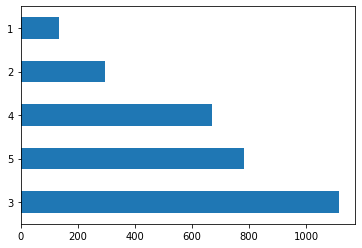

In [55]:
x["cut"].value_counts().plot.barh()

In [56]:
fields=["color","pred","pred_std","price"]
x[fields].groupby("color",as_index=False).mean()

,color,pred,pred_std,price
0,1,7.597366,0.151267,7.587556
1,2,7.733272,0.149237,7.711143
2,3,7.723881,0.125481,7.741544
3,4,7.721060,0.130364,7.684189
4,5,7.729464,0.150393,7.667012
5,6,7.675868,0.153357,7.712573
6,7,7.847129,0.173838,7.811531


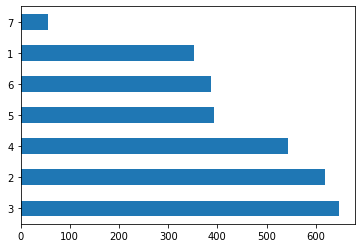

In [57]:
x["color"].value_counts().plot.barh();

In [58]:
def var_importance(rf_model,X_train):
    return pd.DataFrame({"columns":X_train.columns,
                  "importance":rf_model.feature_importances_
                 }).sort_values("importance",ascending=True)

In [59]:
rf_model.feature_importances_

array([0.04940138, 0.00098184, 0.01410971, 0.02745517, 0.00176676,
       0.00140172, 0.04756023, 0.85339012, 0.00393306])

In [60]:
f_importance=var_importance(rf_model,X_train)[:]

In [61]:
f_importance

,columns,importance
1,cut,0.000982
5,table,0.001402
4,depth,0.001767
8,z,0.003933
2,color,0.014110
3,clarity,0.027455
6,x,0.047560
0,carat,0.049401
7,y,0.853390


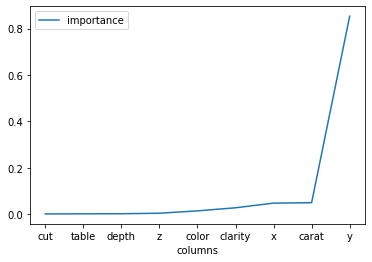

In [62]:
f_importance.plot('columns', 'importance');

In [63]:
def plot_feature_importance(fi): 
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False)

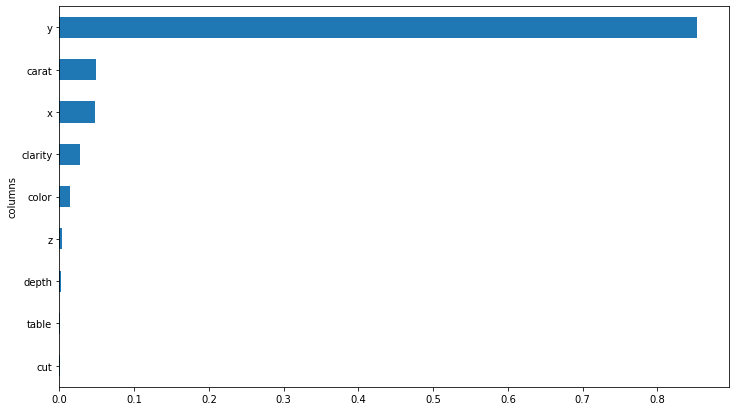

In [64]:
plot_feature_importance(var_importance(rf_model,X_train));

## Partial Dependence

In [65]:
from pdpbox import pdp

In [66]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(rf_model, X_train, X_train.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

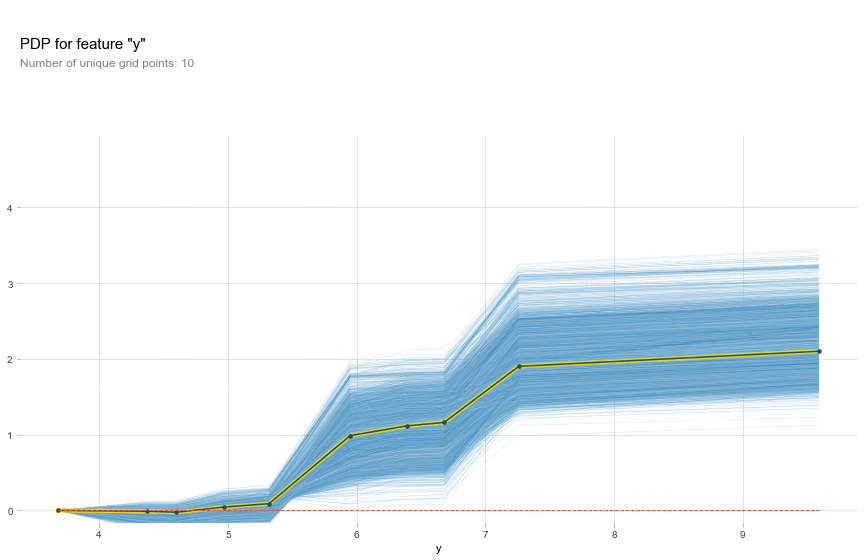

In [67]:
plot_pdp('y');

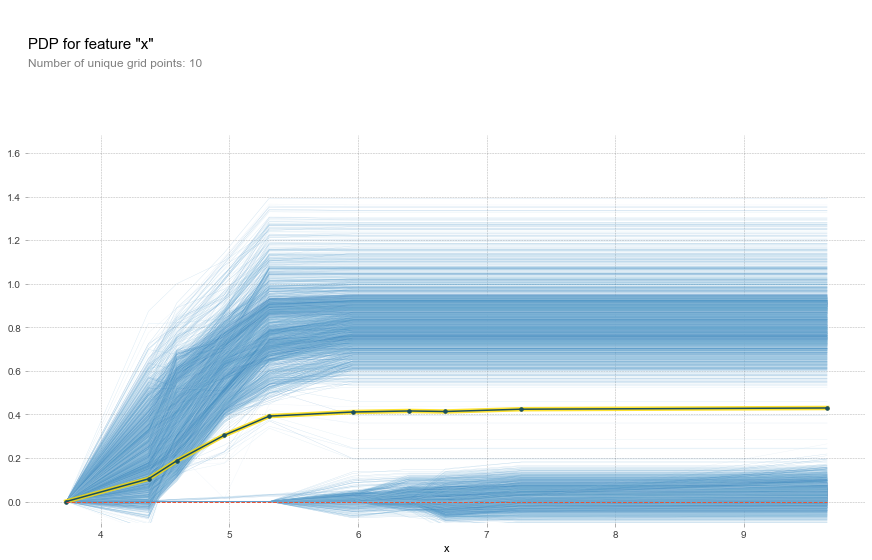

In [68]:
plot_pdp('x');

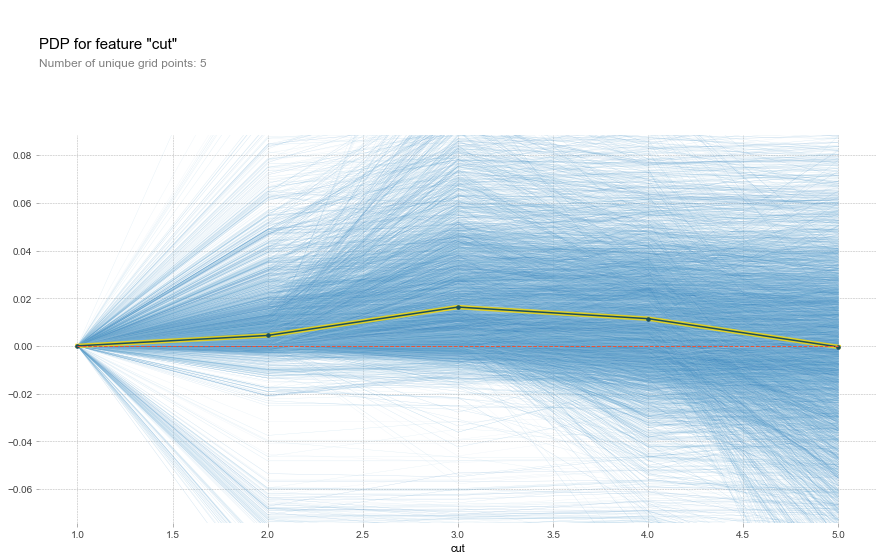

In [69]:
plot_pdp("cut");

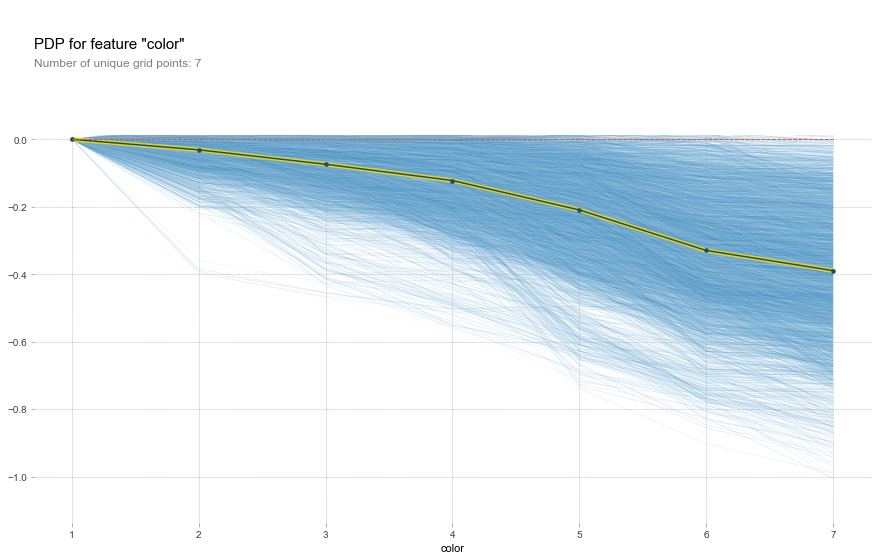

In [70]:
plot_pdp("color");

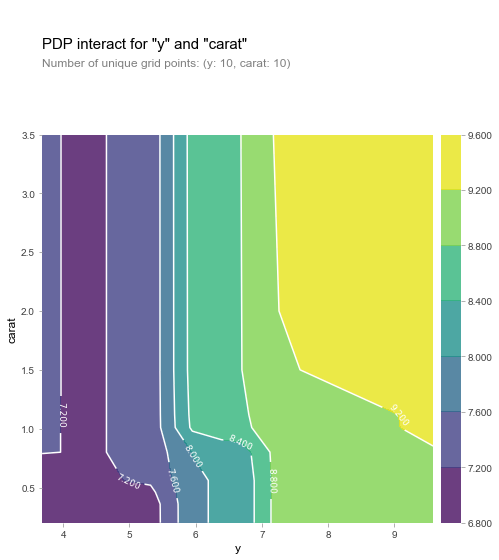

In [71]:
feats = ['y', 'carat']
p = pdp.pdp_interact(rf_model, X_train, X_train.columns, feats)
pdp.pdp_interact_plot(p, feats);

## Final Model


In [84]:
y=y_price

In [85]:
def split_train_validation(df,n):
    return df[:n].copy(),df[n:]

n_validation=3000
n_train=len(df)-n_validation
X_train,X_validation=split_train_validation(df,n_train)
y_train,y_validation=split_train_validation(y,n_train)
def get_sample(df,n):
    idxs=np.random.permutation(len(df))[:n]
    return idxs,df.iloc[idxs].copy()
idxs,X_train=get_sample(X_train,6000)
y_train = y_train[idxs]

In [86]:
rf_model=RandomForestRegressor(n_estimators=100,n_jobs=-1)
%time rf_model.fit(X_train,y_train)
print_(rf_model)

Wall time: 1 s
accuracy train set 0.04327627526605667
accuracy valid set 0.12653557418368638
r^2 train set 0.9982781111184501
r^2 validation set0.9169678054686091
